<a href="https://colab.research.google.com/github/LCCLS/Subjectivity_Mining_Assignment4/blob/main/SM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers
!pip install -q simpletransformers
# OUTPUT OF THIS CELL IS HIDDEN 

     |████████████████████████████████| 5.3 MB 7.8 MB/s 
     |████████████████████████████████| 163 kB 71.3 MB/s 
     |████████████████████████████████| 7.6 MB 45.7 MB/s 
     |████████████████████████████████| 250 kB 6.5 MB/s 
     |████████████████████████████████| 43 kB 982 kB/s 
     |████████████████████████████████| 1.3 MB 48.2 MB/s 
     |████████████████████████████████| 1.9 MB 57.8 MB/s 
     |████████████████████████████████| 9.2 MB 69.0 MB/s 
     |████████████████████████████████| 441 kB 66.6 MB/s 
     |████████████████████████████████| 182 kB 68.9 MB/s 
     |████████████████████████████████| 166 kB 71.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 67.2 MB/s 
     |████████████████████████████████| 162 kB 68.1 MB/s 
     |████████████████████████████████| 162 kB 71.3 MB/s 
     |████████████████████████████████| 158 kB 69.5 MB/s 
     |████████████████████████████████| 157 kB 72.6 MB/s 
     |██████████████

In [2]:
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BartTokenizer, BartModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import os
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statistics import mode
from scipy.special import softmax
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

In [8]:
train = pd.read_csv('/content/olid-train-small.csv')
test = pd.read_csv('/content/olid-test.csv')

train2 = pd.read_csv('/content/hasoc-train.csv')
test2 = pd.read_csv('/content/olid-test.csv')

In [26]:
%%capture
# OUTPUT OF THIS CELL IS HIDDEN 

model_args = ClassificationArgs()
model_args.use_cuda = torch.cuda.is_available()
model_args.overwrite_output_dir = True

bert_id = ClassificationModel(model_type='bert', model_name='bert-base-cased', 
                            use_cuda=True, num_labels=2, args=model_args)

roberta_id = ClassificationModel(model_type='roberta', model_name='roberta-base',
                                       use_cuda=True, num_labels=2, args=model_args)

distilbert_id = ClassificationModel(model_type='distilbert', model_name='distilbert-base-uncased',
                                       use_cuda=True, num_labels=2, args=model_args)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [27]:
%%capture
# OUTPUT OF THIS CELL IS HIDDEN 

bert_id.train_model(train, output_dir = 'bert_in_domain')
roberta_id.train_model(train, output_dir='roberta_in_domain')
distilbert_id.train_model(train, output_dir='distilbert_in_domain')

In [28]:
test_sent = test['text'].to_list()
gold_labels = test['labels'].to_list()

In [29]:
bert_preds_id = bert_id.predict(test_sent)
roberta_preds_id = roberta_id.predict(test_sent)
distilbert_preds_id = distilbert_id.predict(test_sent)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

In [9]:
def plot_confusion_matrix(title_name, test_y=None, sys_y=None, cf=None, stats=None):

    if cf is not None and stats is not None: 
      cf_matrix = cf
      accuracy = stats[0]
      precision = stats[1]
      recall = stats[2]
      f1score = stats[3]

    else: 
      cf_matrix = confusion_matrix(test_y, sys_y)
      accuracy = accuracy_score(test_y, sys_y)
      precision = precision_score(test_y, sys_y, average='macro')
      recall = recall_score(test_y, sys_y, average='macro')
      f1score = f1_score(test_y, sys_y, average='macro')

    group_counts = [f"{int(round(value, 0))}" for value in cf_matrix.flatten()]
    group_percentages = [f"{round(value * 100, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    labels = [f"{v1}\n {v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    stats_text = f"\n\nAccuracy={round(accuracy, 3)}\nPrecision={round(precision, 3)}\nRecall={round(recall, 3)}\nF1 " \
                 f"Score={round(f1score, 3)} "
    figsize = plt.rcParams.get('figure.figsize')
    # x_axis_labels = ['NOT', 'OFF']
    # y_axis_labels = ['NOT', 'OFF']

    plt.figure(figsize=figsize)
    sns.heatmap(cf_matrix, annot=labels, fmt="",
                cmap='Blues', )  # xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)
    plt.title(title_name)
    plt.savefig(f'classification_reports/{title_name}.png', bbox_inches="tight")
    plt.show()
    print('\n')

In [10]:
def metricsReport(modelName, test_labels=None, predictions=None, return_output=False, stacked=None, print_output=True):

    if stacked is not None:
      print("------ Cross-Domain Stacking Ensemble Model Metrics-----")
      print("Accuracy: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
            .format(stacked[0], stacked[1], stacked[2], stacked[3], stacked[4], stacked[5], stacked[6]))
    else: 
      accuracy = accuracy_score(test_labels, predictions)

      macro_precision = precision_score(test_labels, predictions, average='macro')
      macro_recall = recall_score(test_labels, predictions, average='macro')
      macro_f1 = f1_score(test_labels, predictions, average='macro')
      micro_precision = precision_score(test_labels, predictions, average='micro')
      micro_recall = recall_score(test_labels, predictions, average='micro')
      micro_f1 = f1_score(test_labels, predictions, average='micro')

      if return_output: 
        return accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1
      
      if print_output: 
        print("------" + modelName + " Model Metrics-----")
        print("Accuracy: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
              .format(accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1), '\n')
      

In [11]:
def get_ngrams(train_sentences, test_sentences):
  cv = CountVectorizer(analyzer = 'word',ngram_range=(2,2), stop_words='english')
  X_train_cv = cv.fit_transform(train_sentences).toarray()
  X_test_cv = cv.transform(test_sentences).toarray()
  return np.array(X_train_cv), np.array(X_test_cv)


In [12]:
def get_word_count(train_sentences, test_sentences):
  tokenizer = RegexpTokenizer(r'\w+')
  train_sent = [np.array(len(tokenizer.tokenize(text))) for text in train_sentences]
  test_sent = [np.array(len(tokenizer.tokenize(text))) for text in test_sentences]
  return np.array(train_sent), np.array(test_sent)

In [24]:
def get_prediction_correlations(bert, roberta, distilbert):
  b_rb_correlation, b_rb_p_value = stats.pearsonr(bert, roberta)
  rb_db_correlation, rb_db_p_value = stats.pearsonr(roberta, distilbert)
  b_db_correlation, b_db_p_value = stats.pearsonr(bert, distilbert)

  print(f'BERT and ROBERTA correlation: {b_rb_correlation}, with p-value of: {b_rb_p_value}')
  print(f'ROBERTA and DISTILBERT correlation: {rb_db_correlation}, with p-value of: {rb_db_p_value}')
  print(f'BERT and DISTILBERT correlation: {b_db_correlation}, with p-value of: {b_db_p_value}')

In [15]:
def majority_hard_voting(predictions):
  n_of_models = len(predictions)

  if not all(len(x) == len(predictions[0]) for x in predictions):
    raise Exception("All predictions must be the same length.")

  votes = []
  for i in range(len(predictions[0])):
    all_votes = []
    all_votes.extend(predictions[x][i] for x in range(n_of_models))
    votes.append(mode(all_votes))
  return votes

In [16]:
def soft_majority_voting(predictions):
  
  if not all(len(x) == len(predictions[1]) for x in predictions):
    raise Exception("All predictions must be the same length.")

  raw_predictions_bert = softmax(bert_preds_id[1], axis=1)
  raw_predictions_roberta = softmax(roberta_preds_id[1], axis=1)
  raw_predictions_distilbert = softmax(distilbert_preds_id[1], axis=1)

  total_raw_pred = [(b + r + d) / 3 for b, r, d in zip(raw_predictions_bert, raw_predictions_roberta, raw_predictions_distilbert)]
  total_rounded_pred = list(np.where(np.array(total_raw_pred) > 0.5, 1, 0 ))
  total_predictions = [a.tolist().index(1) for a in total_rounded_pred] 

  return total_predictions

In [15]:
def stacking_ensemble(data, k_folds=3):
  
  kf = KFold(n_splits=k_folds,shuffle=True)

  results = []
  cnf = []


  for train_index, val_index in kf.split(data):

      train_df = data.iloc[train_index]
      val_df = data.iloc[val_index]

      val_sent = val_df['text'].to_list()
      val_labels = val_df['labels'].to_list()

      model_args = ClassificationArgs()
      model_args.use_cuda = torch.cuda.is_available()
      model_args.overwrite_output_dir = True
      
      bert_stack = ClassificationModel(model_type='bert', model_name='bert-base-cased', 
                            use_cuda=True, num_labels=2, args=model_args)
      roberta_stack = ClassificationModel(model_type='roberta', model_name='roberta-base',
                                       use_cuda=True, num_labels=2, args=model_args)
      distilbert_stack = ClassificationModel(model_type='distilbert', model_name='distilbert-base-uncased',
                                       use_cuda=True, num_labels=2, args=model_args)

      print('--- TRAINING INITIAL LEARNERS --- ')
      print('--- TRAINING BERT --- ')
      bert_stack.train_model(train_df, output_dir = 'BERT_BASE_MODEL')
      print('--- TRAINING ROBERTA --- ')
      roberta_stack.train_model(train_df, output_dir = 'ROBERTA_BASE_MODEL')
      print('--- TRAINING DISTILBERT --- ')
      distilbert_stack.train_model(train_df, output_dir = 'DISTILBERT_BASE_MODEL')

      print('--- CREATING TRAINING DATA FOR FINAL LEARNER --- ')
      val_pred1 = bert_stack.predict(val_sent)
      val_pred2 = roberta_stack.predict(val_sent)
      val_pred3 = distilbert_stack.predict(val_sent)
      val_soft_pred1 = softmax(val_pred1[1], axis=1)
      val_soft_pred2 = softmax(val_pred2[1], axis=1)
      val_soft_pred3 = softmax(val_pred3[1], axis=1)
      
      print('--- CREATING TESTING DATA FOR FINAL LEARNER --- ')
      test_pred1 = bert_stack.predict(test_sent)
      test_pred2 = roberta_stack.predict(test_sent)
      test_pred3 = distilbert_stack.predict(test_sent)
      test_soft_pred1 = softmax(test_pred1[1], axis=1)
      test_soft_pred2 = softmax(test_pred2[1], axis=1)
      test_soft_pred3 = softmax(test_pred3[1], axis=1)
      
      # additional features 
      val_ngrams, test_ngrams = get_ngrams(val_sent, test_sent)
      val_wc, test_wc = get_word_count(val_sent, test_sent)

      train_stack = np.column_stack((val_soft_pred1, val_soft_pred2, val_soft_pred3, val_ngrams, val_wc))
      test_stack = np.column_stack((test_soft_pred1, test_soft_pred2, test_soft_pred3, test_ngrams, test_wc))

      print('--- TRAINING FINAL LEARNER --- ')
      print('--- TRAINING LOGISTIC REGRESSION ---')
      final_model = LogisticRegression()
      final_model.fit(train_stack, val_labels)
      final_predictions = final_model.predict(test_stack)

      # interpreting results and saving some metrics 
      intermediate_metrics = list(metricsReport('Intermediate Stacking Ensemble', 
                                                test_labels=gold_labels, 
                                                predictions=final_predictions, 
                                                return_output=True,
                                                print_output=True))
      results.append(intermediate_metrics)
      cnf_matrix = confusion_matrix(gold_labels, final_predictions)

      if len(cnf) == 0: 
        cnf = cnf_matrix 
      else: 
        cnf = cnf + cnf_matrix

  mean_results = np.average(np.array(results), axis=0)
  mean_cnf = cnf / k_folds

  return mean_results, mean_cnf

In [16]:
#%%capture
# # OUTPUT OF THIS CELL IS HIDDEN (if the line above is commented out)

merged_data = pd.concat([train2, test2], ignore_index=True)
stacked_res, stacked_cf = stacking_ensemble(merged_data, k_folds=3)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

--- TRAINING INITIAL LEARNERS --- 
--- TRAINING BERT --- 


  0%|          | 0/4474 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- TRAINING ROBERTA --- 


  0%|          | 0/4474 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- TRAINING DISTILBERT --- 


  0%|          | 0/4474 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- CREATING TRAINING DATA FOR FINAL LEARNER --- 


  0%|          | 0/2238 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2238 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2238 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

--- CREATING TESTING DATA FOR FINAL LEARNER --- 


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

--- TRAINING FINAL LEARNER --- 
--- TRAINING LOGISTIC REGRESSION ---


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClass

--- TRAINING INITIAL LEARNERS --- 
--- TRAINING BERT --- 


  0%|          | 0/4475 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- TRAINING ROBERTA --- 


  0%|          | 0/4475 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- TRAINING DISTILBERT --- 


  0%|          | 0/4475 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- CREATING TRAINING DATA FOR FINAL LEARNER --- 


  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

--- CREATING TESTING DATA FOR FINAL LEARNER --- 


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

--- TRAINING FINAL LEARNER --- 
--- TRAINING LOGISTIC REGRESSION ---


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClass

--- TRAINING INITIAL LEARNERS --- 
--- TRAINING BERT --- 


  0%|          | 0/4475 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- TRAINING ROBERTA --- 


  0%|          | 0/4475 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- TRAINING DISTILBERT --- 


  0%|          | 0/4475 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/560 [00:00<?, ?it/s]

--- CREATING TRAINING DATA FOR FINAL LEARNER --- 


  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

--- CREATING TESTING DATA FOR FINAL LEARNER --- 


  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

--- TRAINING FINAL LEARNER --- 
--- TRAINING LOGISTIC REGRESSION ---


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [30]:
all_predictions = [bert_preds_id[0], roberta_preds_id[0], distilbert_preds_id[0]]

hard_ensemble_olid = majority_hard_voting(all_predictions)
soft_ensemble_olid = soft_majority_voting(all_predictions)

In [31]:
import scipy.stats as stats
get_prediction_correlations(all_predictions[0], all_predictions[1], all_predictions[2])

BERT and ROBERTA correlation: 0.756530431339952, with p-value of: 1.9857443510003296e-160
ROBERTA and DISTILBERT correlation: 0.71284564484269, with p-value of: 2.389001601799041e-134
BERT and DISTILBERT correlation: 0.7437931346267396, with p-value of: 2.818301902230258e-152


------Cross-Domain Majority Hard Voting Ensemble Model Metrics-----
Accuracy: 0.8070
Precision:
  - Macro: 0.7996
  - Micro: 0.8070
Recall:
  - Macro: 0.6886
  - Micro: 0.8070
F1-measure:
  - Macro: 0.7131
  - Micro: 0.8070 

------Cross-Domain Majority Soft Voting Ensemble Model Metrics-----
Accuracy: 0.8081
Precision:
  - Macro: 0.7912
  - Micro: 0.8081
Recall:
  - Macro: 0.6984
  - Micro: 0.8081
F1-measure:
  - Macro: 0.7219
  - Micro: 0.8081 

------ Cross-Domain Stacking Ensemble Model Metrics-----
Accuracy: 0.9101
Precision:
  - Macro: 0.9162
  - Micro: 0.9101
Recall:
  - Macro: 0.8568
  - Micro: 0.9101
F1-measure:
  - Macro: 0.8802
  - Micro: 0.9101


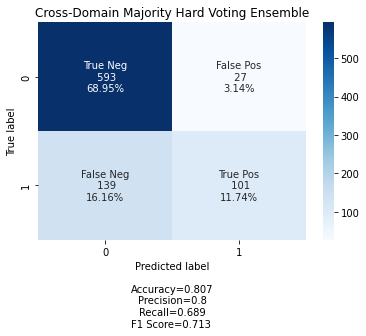

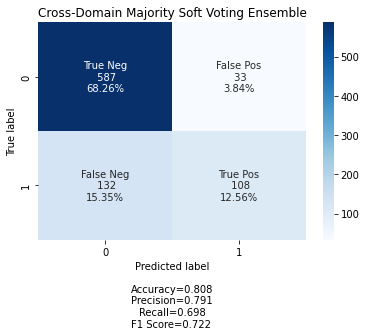

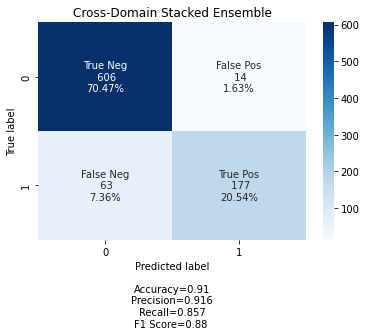

In [18]:
metricsReport('Cross-Domain Majority Hard Voting Ensemble', test_labels=gold_labels, predictions=hard_ensemble_olid)
metricsReport('Cross-Domain Majority Soft Voting Ensemble', test_labels=gold_labels, predictions=soft_ensemble_olid)
metricsReport('Cross-Domain Stacked Ensemble', stacked=stacked_res)

plot_confusion_matrix('Cross-Domain Majority Hard Voting Ensemble', gold_labels, hard_ensemble_olid)
plot_confusion_matrix('Cross-Domain Majority Soft Voting Ensemble', gold_labels, soft_ensemble_olid)
plot_confusion_matrix('Cross-Domain Stacked Ensemble', cf = stacked_cf, stats=[stacked_res[0], stacked_res[1], stacked_res[3], stacked_res[5]])